In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [2]:
import pandas as pd
import numpy as np
import requests

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

from myFunctions import *

# Load X and y

In [19]:
X=pd.read_csv('filteredAnnualStockFeatures_2021.csv', index_col=0)
y=pd.read_csv('filteredAnnualStockPerformance_2021.csv', index_col=0)

In [20]:
# randomize the rows
X['y'] = y
X = X.sample(frac=1.0, random_state=42) # randomize the rows
y = X['y']
X.drop(columns=['y'], inplace=True)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=42)

# Create Predictors

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

lin_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('Enet', ElasticNet(random_state=42))])

rf_regr = RandomForestRegressor(random_state=42, 
                                max_depth=30)

ert_regr = ExtraTreesRegressor(random_state=42, n_estimators=100, max_depth=30)

knn_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('knn', KNeighborsRegressor(n_neighbors=40))])

svm_regr = Pipeline([('powerTransformer', PowerTransformer()), 
                     ('svr', SVR())])

# Use Model

In [23]:
rf_regr.fit(X_train, y_train)
y_pred = rf_regr.predict(X_test)

<ipython-input-23-40537ddd4f90>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(X_train, y_train)


# See Predictions

In [24]:
def calcZScores(x):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame(index=x.index)
    Z = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['BookEquity/TL']
    return Z

In [25]:
def getPredictionInfo(y_pred, y_test, X_test, 
                      stockData, priceData, 
                      zScoreFilter=False):
    '''
    Combine the y predictions with corresponding stock 
    feature/price information used in training.
    Returns big DataFrame sorted by stock return prediction value.
    '''
    stockData['date']=pd.to_datetime(stockData['date'])
    predInfo = stockData.loc[X_test.index].copy()
    predInfo['Prediction'] = y_pred
    predInfo['Target'] = y_test
    predInfo['buyDate'] = pd.to_datetime(priceData.loc[X_test.index]['startDate'])
    predInfo['sellDate'] = pd.to_datetime(priceData.loc[X_test.index]['endDate'])
    predInfo['buyPrice'] = priceData.loc[X_test.index]['startClose']
    predInfo['sellPrice'] = priceData.loc[X_test.index]['endClose']
    predInfo['startAdjusted'] = priceData.loc[X_test.index]['startAdjusted_close']
    predInfo['endAdjusted'] = priceData.loc[X_test.index]['endAdjusted_close']
    
    # If we want Z score:
    predInfo['zScore'] = calcZScores(X_test)
    if zScoreFilter:
        predInfo=predInfo.loc[calcZScores(X_test) > zScoreFilter]
        
    predInfo = predInfo.sort_values(by=['Prediction']).reset_index(drop=True)
    #print(predInfo.shape)
    return predInfo

In [26]:
stockData = pd.read_csv('stockData_2021_filtered.csv', index_col=0)
priceData = pd.read_csv('priceData_2021.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,11,13,15,23,24,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [29]:
predInfo = getPredictionInfo(y_pred, y_test, X_test, stockData, priceData)

In [30]:
predInfo.tail(20)[['Code', 'Exchange','CountryName','date','buyDate','sellDate',\
             'startAdjusted','endAdjusted','Prediction','Target','zScore']]

,Code,Exchange,CountryName,date,buyDate,sellDate,startAdjusted,endAdjusted,Prediction,Target,zScore
122833,CLA,PA,France,2016-06-30,2016-10-28,2017-10-30,1.0600,4.8600,3.178244,3.584906,-6.831255
122834,CADN,SW,Switzerland,2013-12-31,2014-04-30,2015-04-30,0.7200,1.5000,3.241538,1.083333,6.331816
122835,NURO,NASDAQ,USA,2017-12-31,2018-04-30,2019-04-30,13.7000,8.2710,3.282409,-0.396277,-66.516441
122836,AZR,SG,Singapore,2016-03-31,2016-08-03,2017-07-31,0.0600,0.3800,3.321351,5.333333,99.455821
122837,VINO,NASDAQ,USA,2019-12-31,2020-04-29,2021-04-29,0.3500,3.7600,3.345423,9.742857,-56.346660
122838,FGO,AU,Australia,2015-06-30,2015-10-28,2016-10-27,6.0000,0.0380,3.441143,-0.993667,-102.464947
122839,GLL,CN,Canada,2018-06-30,2018-10-29,2019-10-28,1.3500,0.0500,3.470202,-0.962963,-60.509648
122840,BOU,SG,Singapore,2014-03-31,2014-07-29,2015-07-29,0.0041,0.0022,3.498579,-0.463415,8.982184
122841,ANIX,NASDAQ,USA,1999-10-31,2000-02-28,2001-02-27,53.9050,19.9225,3.549620,-0.630415,-15.749691
122842,GRW,IR,Ireland,2016-03-31,2016-07-29,2017-07-31,3.4500,3.5980,3.563792,0.042899,39.063800


In [41]:
predInfo.tail(20)[['Code', 'Exchange','CountryName','date','buyDate','sellDate',\
             'startAdjusted','endAdjusted','Prediction','Target','zScore']]

,Code,Exchange,CountryName,date,buyDate,sellDate,startAdjusted,endAdjusted,Prediction,Target,zScore
122833,ICSA,NSE,India,2019-03-31,2019-07-29,2020-07-28,1.0500,0.2000,3.115671,-0.809524,-97.388611
122834,USIO,NASDAQ,USA,2010-12-31,2011-05-02,2012-04-30,0.3600,1.3500,3.139167,2.750000,-66.851578
122835,SWKH,NASDAQ,USA,2009-12-31,2010-04-30,2011-05-02,9.4000,8.8000,3.147998,-0.063830,47.753900
122836,PWF,TO,Canada,2016-12-31,2017-05-02,2018-04-30,0.0038,0.0350,3.366655,8.210526,3.629046
122837,EQ,V,Canada,2014-12-31,2015-04-30,2016-04-29,0.0700,0.0400,3.398838,-0.428571,-77.000809
122838,GODAVARI,BSE,India,2014-03-31,2014-07-29,2015-07-29,8.2500,65.5000,3.450392,6.939394,5.386210
122839,GRW,IR,Ireland,2016-03-31,2016-07-29,2017-07-31,3.4500,3.5980,3.551416,0.042899,39.063800
122840,RMG,AU,Australia,2016-06-30,2016-10-28,2017-10-30,0.0150,0.0150,3.592454,0.000000,-84.240370
122841,TGNA,NYSE,USA,2008-12-31,2009-04-30,2010-04-30,1.5031,6.6635,3.613250,3.433171,0.677324
122842,R3D,AU,Australia,2017-06-30,2017-10-30,2018-10-29,0.0300,0.0070,3.628034,-0.766667,-49.866678


In [42]:
predInfo.head(20)[['Code', 'Exchange','CountryName','date','buyDate','sellDate',\
             'startAdjusted','endAdjusted','Prediction','Target','zScore']]

,Code,Exchange,CountryName,date,buyDate,sellDate,startAdjusted,endAdjusted,Prediction,Target,zScore
0,CYQ,AU,Australia,2010-06-30,2010-10-28,2011-10-28,34.7222,14.4444,-0.492830,-0.584001,5.506309
1,KTOV,TA,Israel,2011-12-31,2012-04-29,2013-04-29,26000.0000,13000.0000,-0.455650,-0.500000,1.380056
2,MADHUCON,BSE,India,2018-03-31,2018-07-30,2019-07-29,11.8600,4.7700,-0.444025,-0.597808,-2.723311
3,IMC,AU,Australia,2003-06-30,2003-10-28,2004-10-27,331.7680,495.1720,-0.441591,0.492525,8.162780
4,PDL,LSE,UK,2007-06-30,2007-10-29,2008-10-27,119.3527,69.9654,-0.432827,-0.413793,4.718033
5,ITM,LSE,UK,2008-04-30,2008-08-28,2009-08-28,51.9161,28.8423,-0.424090,-0.444444,50.624968
6,CUEN,NASDAQ,USA,2014-12-31,2015-05-01,2016-04-29,37.5000,179.0625,-0.414495,3.775000,-102.444054
7,CWR,LSE,UK,2005-06-30,2005-10-28,2006-10-30,944.1282,1614.9562,-0.413818,0.710526,42.852091
8,VMT,AU,Australia,2003-12-31,2004-04-29,2005-04-29,14.5000,10.0000,-0.411695,-0.310345,11.494002
9,DEG,AU,Australia,2003-06-30,2003-10-28,2004-10-27,56.7400,173.3700,-0.411525,2.055516,61.114032


In [43]:
from sklearn.metrics import mean_squared_error
takeL = 20

bestPredictions = predInfo['Prediction'].iloc[-20:]
bestTargets = predInfo['Target'].iloc[-20:]
worstPredictions = predInfo['Prediction'].iloc[:20]
worstTargets = predInfo['Target'].iloc[:20]

print('First and last ',takeL, 'stocks by predicted return:')
print('\tHighest return stocks:')
print('\t\tPrediction mean return:', round(np.mean(bestPredictions),3), 
      'Actual return:', round(np.mean(bestTargets),3))
print('\t\tPrediction RMSE: ', round(np.sqrt(mean_squared_error(bestPredictions, bestTargets)),3))

print('\tFor lowest return stocks:')
print('\t\tPrediction mean return:', round(np.mean(worstPredictions),3), 
      'Actual return:', round(np.mean(worstTargets),3))
print('\t\tPrediction RMSE: ', round(np.sqrt(mean_squared_error(worstPredictions, worstTargets)),3))

First and last  20 stocks by predicted return:
	Highest return stocks:
		Prediction mean return: 3.957 Actual return: 4.101
		Prediction RMSE:  3.483
	For lowest return stocks:
		Prediction mean return: -0.413 Actual return: 0.172
		Prediction RMSE:  1.437


In [10]:
def plotPredTgt(l, predData, 
                title='Actual Returns of Top and Bottom 100 Predicted Stock Returns', 
                sideBySide=False):
    '''
    Takes sorted prediction data output and plots 
    best and worst 'l' stock selections.
    '''
    # Select start and end positions in the DataFrame
    end = predData.shape[0]-1
    start = end - l
    select = list(range(start,end))
    plt.figure(figsize=(15,8))
    
    if not sideBySide:
        plt.subplot(2,1,1)
    else:
        plt.subplot(1,2,1)
        
    plt.plot(select, predData['Prediction'].iloc[-l:],'x')
    plt.plot(select, predData['Target'].iloc[-l:],'o')
    plt.plot([start, end], 
             [np.mean(predData['Target'].iloc[-l:]), 
              np.mean(predData['Target'].iloc[-l:])])
    plt.xlabel('Data row number')
    plt.ylabel('Stock annual return')
    plt.legend(['Stock return prediction',
                'Stock return actual', 
                'Mean of actual '+str(l)+\
                ' stock returns with highest return prediction'])
    plt.suptitle(title, fontsize=20)
    plt.ylim([-1, 12])
    plt.grid()
    select = list(range(0,l))
    if not sideBySide:
        plt.subplot(2,1,2)
    else:
        plt.subplot(1,2,2)
    plt.plot(select, predData['Prediction'].iloc[:l],'x')
    plt.plot(select, predData['Target'].iloc[:l],'o')
    plt.plot([0, l], 
             [np.mean(predData['Target'].iloc[:l]), 
              np.mean(predData['Target'].iloc[:l])])
    plt.xlabel('Data row number')
    plt.ylabel('Stock annual return')
    plt.legend(['Stock return prediction',
                'Stock return actual', 
                'Mean of actual '+str(l)+\
                ' stock returns with lowest return prediction'])
    plt.ylim([-1, 12])
    plt.grid()

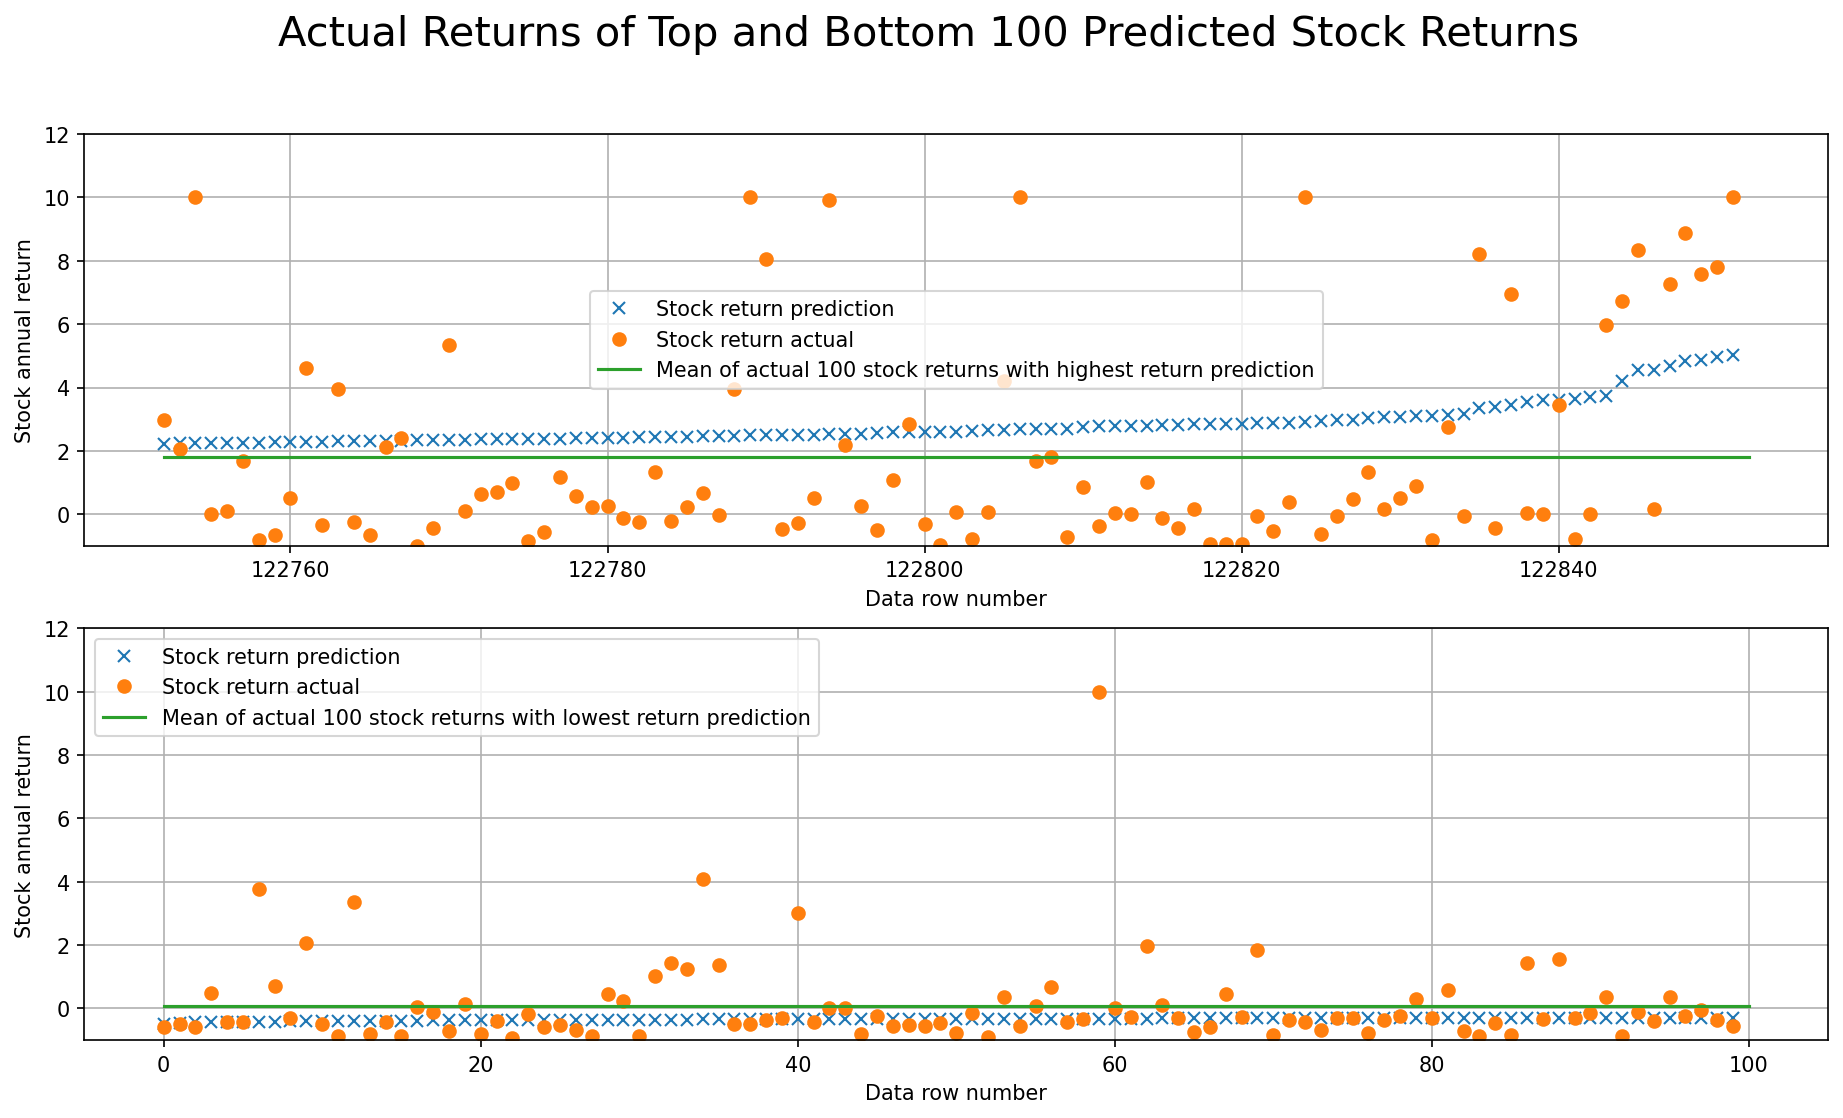

In [45]:
plotPredTgt(100, predInfo)

Text(0.5, 0, 'Relative Return (1 for 100%, -1 for -100%)')

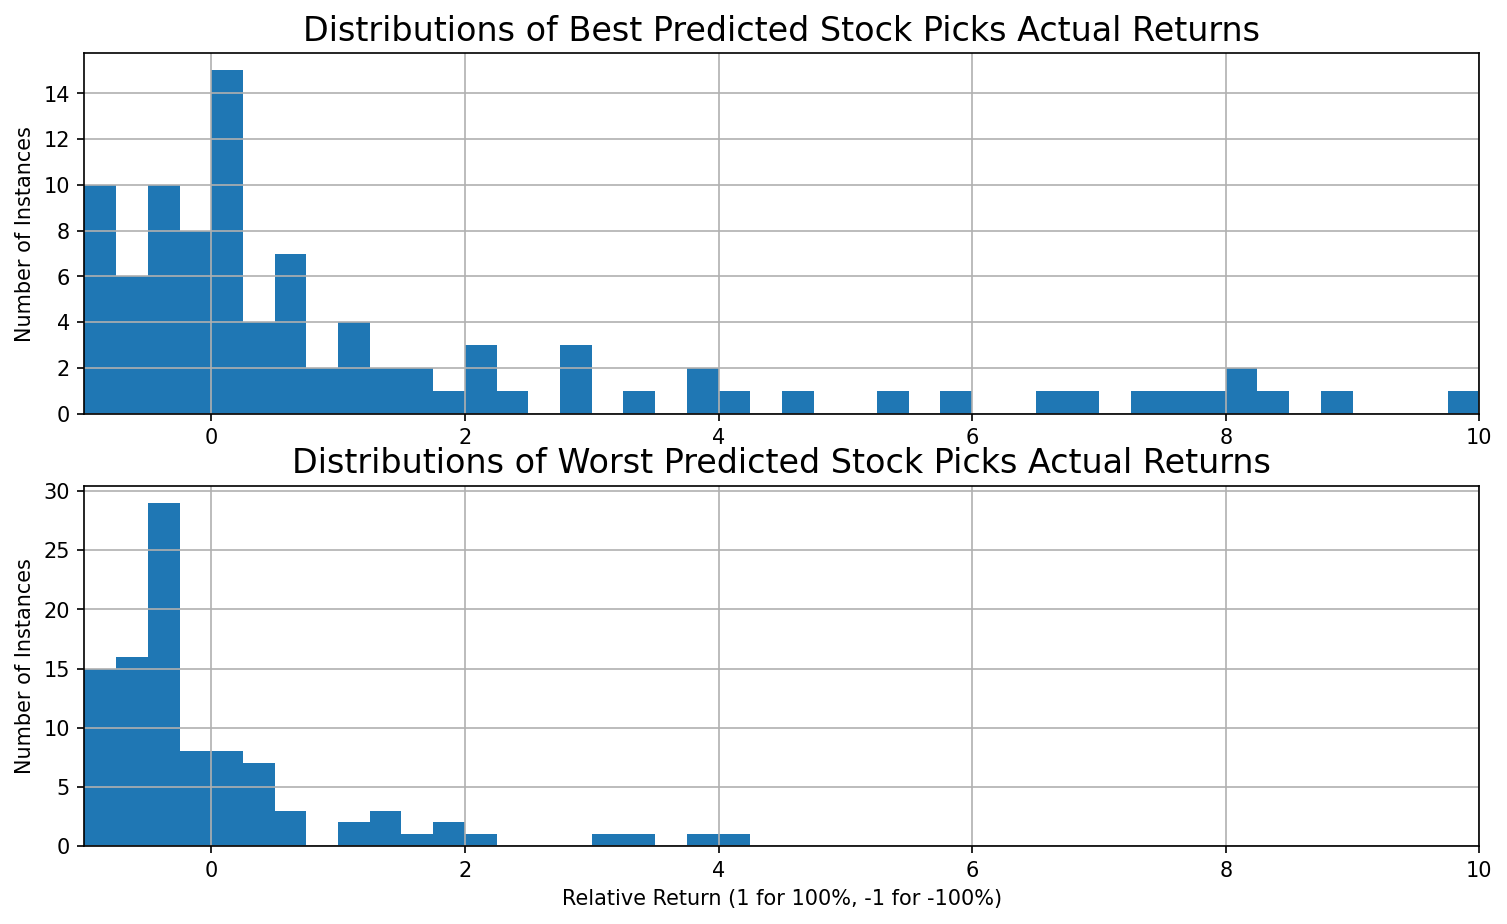

In [46]:
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
predInfo['Target'].iloc[-100:].hist(bins=np.arange(-1,11,0.25))
plt.xlim([-1,10])
plt.title('Distributions of Best Predicted Stock Picks Actual Returns', fontsize=16)
plt.ylabel('Number of Instances')
#plt.xlabel('Relative Return (1 for 100%, -1 for -100%)')
plt.subplot(2,1,2)
predInfo['Target'].iloc[:100].hist(bins=np.arange(-1,11,0.25))
plt.xlim([-1,10])
plt.title('Distributions of Worst Predicted Stock Picks Actual Returns', fontsize=16)
plt.ylabel('Number of Instances')
plt.xlabel('Relative Return (1 for 100%, -1 for -100%)')

In [47]:
bl1 = predInfo['Code'] == 'PFC'
bl2 = predInfo['CountryName'] == 'UK'
predInfo[bl1 & bl2][['Code', 'Exchange','CountryName',\
                     'date','buyDate','sellDate',\
                     'startAdjusted','endAdjusted',\
                     'Prediction','Target']]

,Code,Exchange,CountryName,date,buyDate,sellDate,startAdjusted,endAdjusted,Prediction,Target
40025,PFC,LSE,UK,2017-12-31,2018-04-30,2019-04-30,601.9867,442.4333,0.110622,-0.265045
52998,PFC,LSE,UK,2013-12-31,2014-04-30,2015-04-30,1445.4742,869.9448,0.135257,-0.398160
69709,PFC,LSE,UK,2006-12-31,2007-04-30,2008-04-29,408.3263,538.0255,0.175642,0.317636
70720,PFC,LSE,UK,2015-12-31,2016-04-29,2017-05-02,841.4984,819.2244,0.178554,-0.026469
97028,PFC,LSE,UK,2005-12-31,2006-05-02,2007-04-30,328.2341,408.3263,0.283177,0.244009
100059,PFC,LSE,UK,2007-12-31,2008-04-29,2009-04-29,538.0255,535.7079,0.303229,-0.004308
100704,PFC,LSE,UK,2012-12-31,2013-04-30,2014-04-30,1342.6207,1445.4742,0.307924,0.076607
103992,PFC,LSE,UK,2010-12-31,2011-05-03,2012-04-30,1491.0494,1725.0146,0.334522,0.156913
104364,PFC,LSE,UK,2009-12-31,2010-04-30,2011-05-03,1130.0071,1491.0494,0.337898,0.319504
115298,PFC,LSE,UK,2011-12-31,2012-04-30,2013-04-29,1725.0146,1322.7300,0.513680,-0.233206


# Same With Altman-Z cutoff scores:

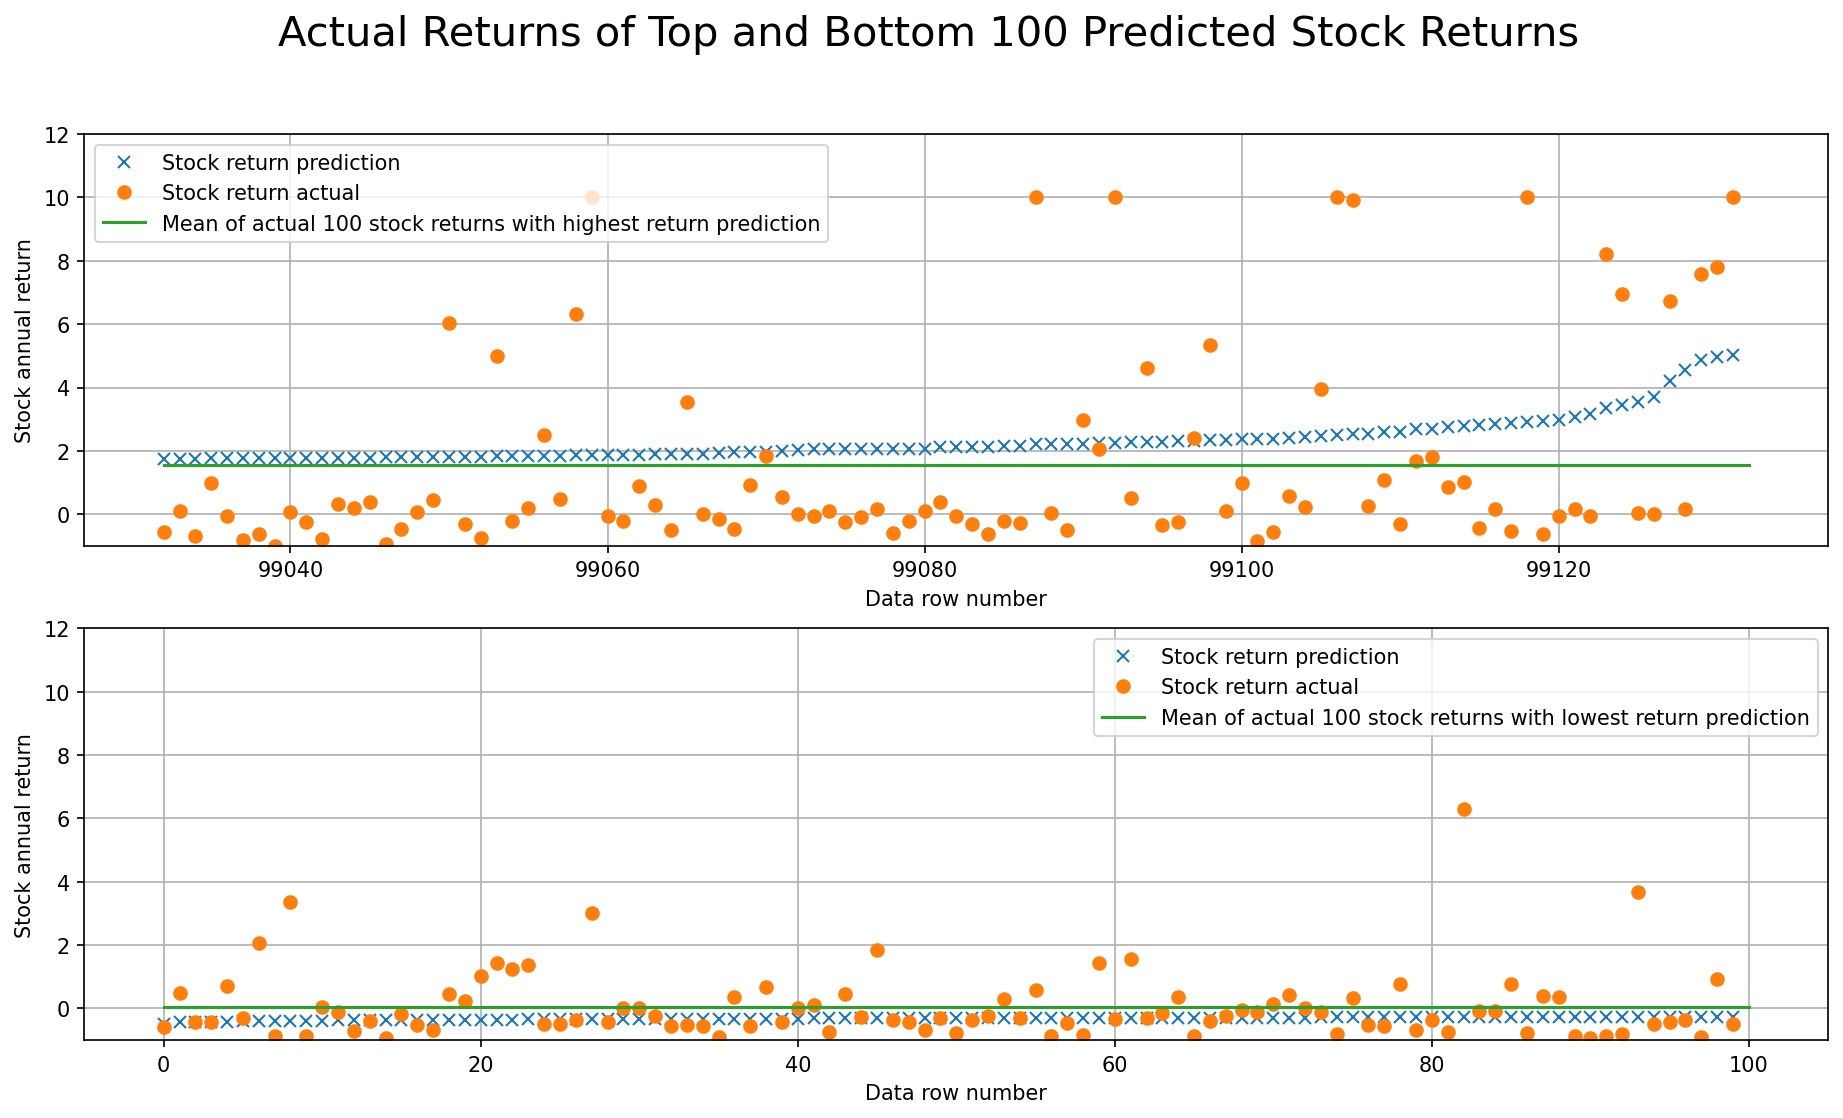

In [53]:
predInfoWithZScores = getPredictionInfo(y_pred, y_test, X_test, 
                                        stockData, priceData, 
                                        zScoreFilter=2.6)
plotPredTgt(100, predInfoWithZScores)

# Try All The Models

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

def createNewRegressor(regressorName):
    '''
    Return a new regressor, specifying the type with a string.
    In parallel we want to create a new regressor for each thread,
    so we need this function.
    '''
    
    if regressorName == 'linearRegression':
        return Pipeline([('powerTransformer', PowerTransformer()), 
                         ('Enet', ElasticNet(random_state=42))])
    
    elif regressorName == 'randomForest':
        return RandomForestRegressor(random_state=42, 
                                     max_depth=30)
    elif regressorName == 'extraTrees':
        return ExtraTreesRegressor(random_state=42, 
                                   n_estimators=100, 
                                   max_depth=30)

    elif regressorName == 'gradBoost':
        return GradientBoostingRegressor(random_state=2)
    
    elif regressorName == 'KNN':
        return  Pipeline([('powerTransformer', PowerTransformer()), 
                          ('knn', KNeighborsRegressor(n_neighbors=40))])
    
    elif regressorName == 'SVM':
        return Pipeline([('powerTransformer', PowerTransformer()), 
                         ('svr', SVR())])
    else:
        return False

In [12]:
import os

def testPredictorStockReturns(regressorsNames, 
                              numRuns=3, 
                              verbose=False, 
                              multithreadingLock=False,
                              resultsFileName='Stock_Picking_Performance_With_Lookahead_Bias.csv'
                              ):
    '''
    Tests a list of regressors for stock return.
    Performance is measured as top/bottom 20 stock predictions.
    
    Train/test split differs each time.
    
    writes to a file results of top/bottom 20 stock returns,
    and top/bottom 20 stock returns with an Altman-Z cut-off of 2.6
    '''
    returnCols = ['Predictor',
                  'Top20Return', 'Bottom20Return',
                  'Top20Return_withZscoreCutoff', 
                  'Bottom20Return_withZscoreCutoff']
    
    # Iterate through all regressorsNames
    for regressorName in regressorsNames:
        # Run each regressor a number of times
        for runNum in range(0, numRuns):
            # Split the data into test/train sets
            X_train, X_test, y_train, y_test = \
            train_test_split(X, np.array(y).ravel(), 
                             test_size=0.5) # random every time, no random state.
            
            # create the model (in parallel we want these separate)
            regressor = createNewRegressor(regressorName)
            
            # Fit the model, make predictions.
            regressor.fit(X_train,y_train)      
            y_pred = regressor.predict(X_test)
            
            # get the prediction data WITHOUT Z score cut-off
            predData = getPredictionInfo(y_pred, y_test, X_test, 
                                         stockData, priceData)
            
            # get the prediction data WITH Z score cut-off
            predDataWithZScoreCutoff = getPredictionInfo(y_pred, y_test, X_test, 
                                                         stockData, priceData,
                                                         zScoreFilter=2.6)
            
            # Find the best and the worst predicted stocks
            bestTargets = predData['Target'].iloc[-20:]
            worstTargets = predData['Target'].iloc[:20]
            bestTargetsZScoreCutoff=predDataWithZScoreCutoff['Target'].iloc[-20:]
            worstTargetsZScoreCutoff=predDataWithZScoreCutoff['Target'].iloc[:20]
        
            # Get the predictor name
            if type(regressor).__name__ == 'Pipeline': 
                extractedRegressorName = type(regressor[1]).__name__
            else:
                extractedRegressorName = type(regressor).__name__
            
            # Store the results in a DataFrame
            results = pd.DataFrame([[extractedRegressorName, 
                                    np.mean(bestTargets),
                                    np.mean(worstTargets),
                                    np.mean(bestTargetsZScoreCutoff), 
                                    np.mean(worstTargetsZScoreCutoff)]],
                                   columns=returnCols)
            
            if verbose:
                print(list(results.iloc[0]))
                
            # Record the results to file. 
            
            
            # If run in parallel use the multithreading lock
            # so that no two CPUS will read the file at the same time
            if (multithreadingLock):
                with multithreadingLock:
                    results.to_csv(resultsFileName, 
                                   mode='a', 
                                   header=not os.path.exists(resultsFileName))  
                    
            # If not in parallel, just write the results to file
            else:
                results.to_csv(resultsFileName, 
                               mode='a', 
                               header=not os.path.exists(resultsFileName))  
            
    pass # don't return anything

In [48]:
testPredictorStockReturns(['randomForest',
                           'extraTrees',
                           'gradBoost',
                           'KNN'], 
                          numRuns=1, 
                          verbose=True,
                          resultsFileName='Stock_Picking_Performance_With_Lookahead_Bias.csv')

['Predictor', 'Top20Return', 'Bottom20Return', 'Top20Return_withZscoreCutoff', 'Bottom20Return_withZscoreCutoff']


## In Parallel

In [52]:
import os # to write to results file
import threading # multithreading

def runInParallel(regressors, numRuns=3, numberOfThreads=4):
    resultsFileName = 'Stock_Picking_Performance_With_Lookahead_Bias.csv'
    multithreadingLock = threading.Lock()
    thread_list = []
    for i in range(numberOfThreads):
        thread = threading.Thread(target=testPredictorStockReturns, 
                                  args=(regressors,
                                        numRuns,
                                        False,
                                        multithreadingLock))

        thread_list.append(thread)
        thread.start()
        
    return thread_list

In [57]:
#thread_list = runInParallel([knn_regr], numRuns=1, numberOfThreads=4)

thread_list = runInParallel(['randomForest',
                             'extraTrees',
                             'gradBoost',
                             'KNN'], numRuns=10, numberOfThreads=4)

In [95]:
for i in thread_list:
    print(i.is_alive())

True
True
True
True
True
True
True
True
True
True


## See Results

In [33]:
y.mean() # average return if stocks chosen randomly (remember lookahead bias is present)

0.18318386034896172

In [99]:
runs=pd.read_csv('Stock_Picking_Performance_With_Lookahead_Bias.csv', index_col=0)
runs

,Unnamed: 0,Predictor,Top20Return,Bottom20Return,Top20Return_withZscoreCutoff,Bottom20Return_withZscoreCutoff
0,0,KNeighborsRegressor,0.744866,0.233442,0.774589,0.243960
1,0,KNeighborsRegressor,1.173348,0.300611,0.247167,0.248759
2,0,RandomForestRegressor,1.087684,-0.409655,0.390683,-0.336775
3,1,RandomForestRegressor,0.256578,0.457845,0.308450,-0.163751
4,2,RandomForestRegressor,9.449191,-0.851602,8.962628,-0.829918
...,...,...,...,...,...,...
585,0,KNeighborsRegressor,0.510642,-0.222069,0.046289,-0.118437
586,0,KNeighborsRegressor,0.923745,-0.165512,0.034728,-0.395347
587,0,KNeighborsRegressor,1.346516,0.094046,0.180997,0.088258
588,0,KNeighborsRegressor,0.829392,0.506502,0.844539,0.292984


In [100]:
print(list(runs['Predictor'].unique()))
print(list(runs['Predictor'].value_counts()))

['KNeighborsRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
[130, 130, 130, 130, 70]


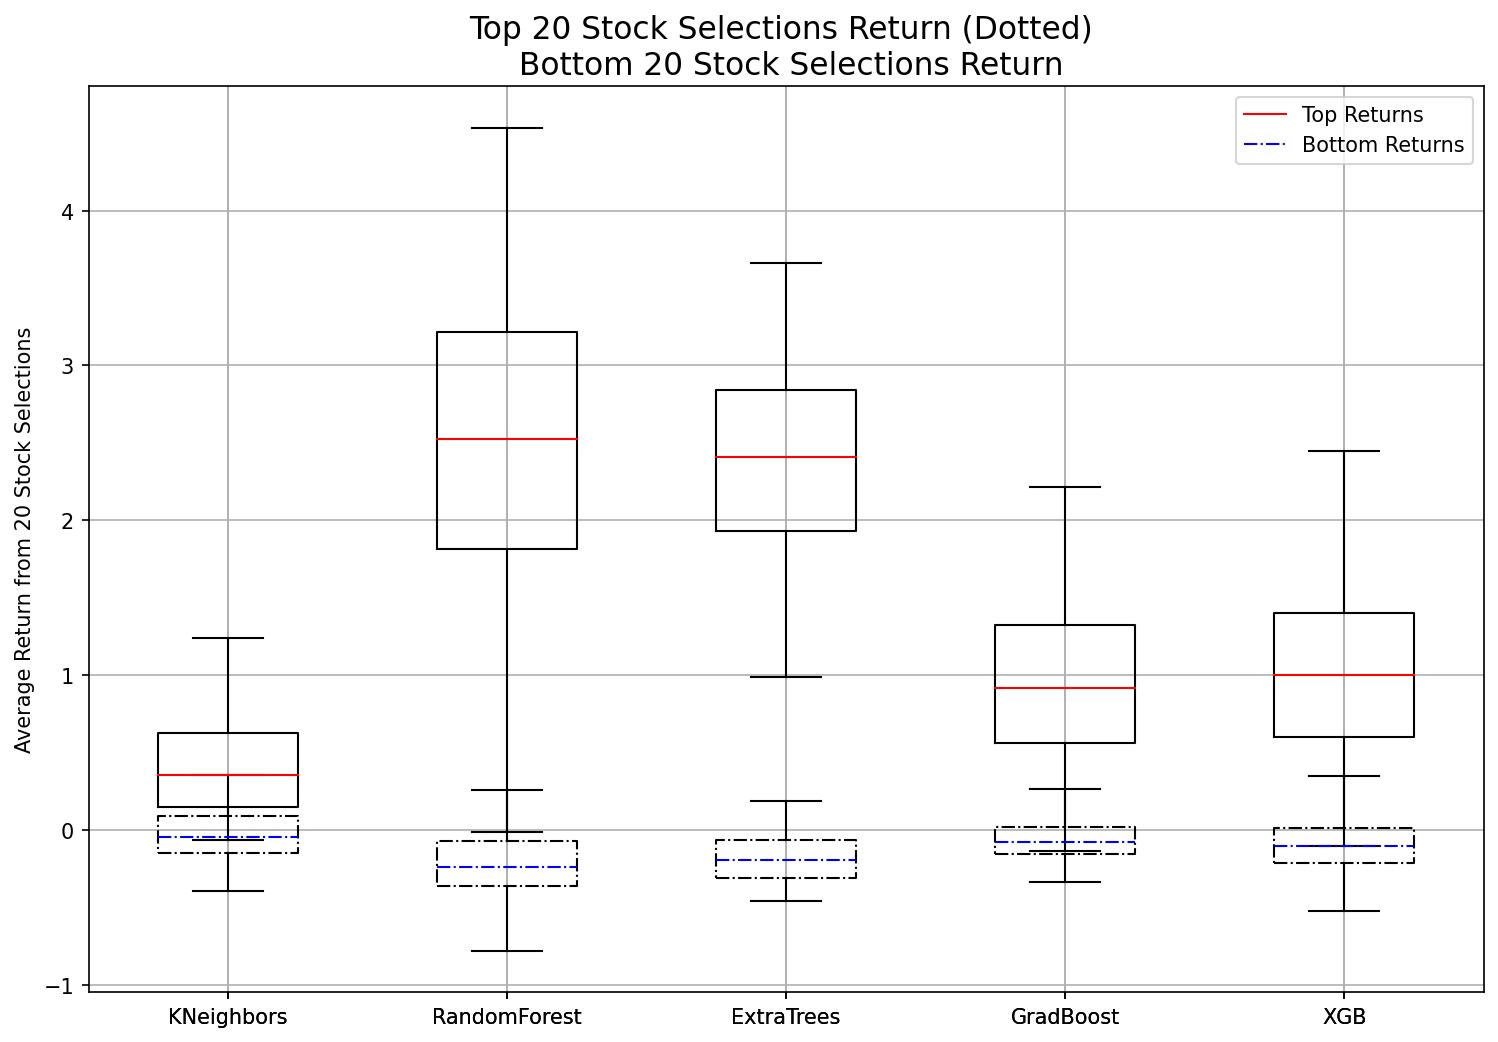

In [101]:
from matplotlib.lines import Line2D
plt.figure(figsize=(12,8))

topColString = 'Top20Return_withZscoreCutoff'
botColString = 'Bottom20Return_withZscoreCutoff'

plt.boxplot([runs[runs['Predictor']=='KNeighborsRegressor'][topColString],
             runs[runs['Predictor']=='RandomForestRegressor'][topColString],
             runs[runs['Predictor']=='ExtraTreesRegressor'][topColString],
             runs[runs['Predictor']=='GradientBoostingRegressor'][topColString]],
             labels=['KNeighbors',
                     'RandomForest',
                     'ExtraTrees',
                     'GradBoost'],
            medianprops={'color':'r'},
            showfliers=False
            );
plt.boxplot([runs[runs['Predictor']=='KNeighborsRegressor'][botColString],
             runs[runs['Predictor']=='RandomForestRegressor'][botColString],
             runs[runs['Predictor']=='ExtraTreesRegressor'][botColString],
             runs[runs['Predictor']=='GradientBoostingRegressor'][botColString]],
             labels=['KNeighbors',
                     'RandomForest',
                     'ExtraTrees',
                     'GradBoost'],
            medianprops={'color':'b',
                         'linestyle':'-.'}, 
            boxprops={'linestyle':'-.'}, 
            showfliers=False
            );

lines = [Line2D([0], [0], color='red', linewidth=1, linestyle='-'),
         Line2D([0], [0], color='blue', linewidth=1, linestyle='-.')]
labels = ['Top Returns', 'Bottom Returns']
plt.legend(lines, labels)

plt.grid()
plt.title('Top 20 Stock Selections Return (Dotted) \n Bottom 20 Stock Selections Return', fontsize=15);
plt.ylabel('Average Return from 20 Stock Selections', fontsize=10);

# See The Best And Worst Regressor Predictions Up Close

In [37]:
# Best predictor
ert_regr.fit(X_train, y_train)
y_pred_ert = ert_regr.predict(X_test)

predInfo_ert = getPredictionInfo(y_pred_ert, y_test, X_test, stockData, priceData)    
#predInfo_ert.tail(20)[['Code', 'Exchange','CountryName','date','buyDate','sellDate',\
#                     'startAdjusted','endAdjusted','Prediction','Target']]

# Worst predictor
knn_regr.fit(X_train, y_train)
y_pred_knn = knn_regr.predict(X_test)

predInfo_knn = getPredictionInfo(y_pred_knn, y_test, X_test, stockData, priceData)    
#predInfo_knn.tail(20)[['Code', 'Exchange','CountryName','date','buyDate','sellDate',\
#                     'startAdjusted','endAdjusted','Prediction','Target']]

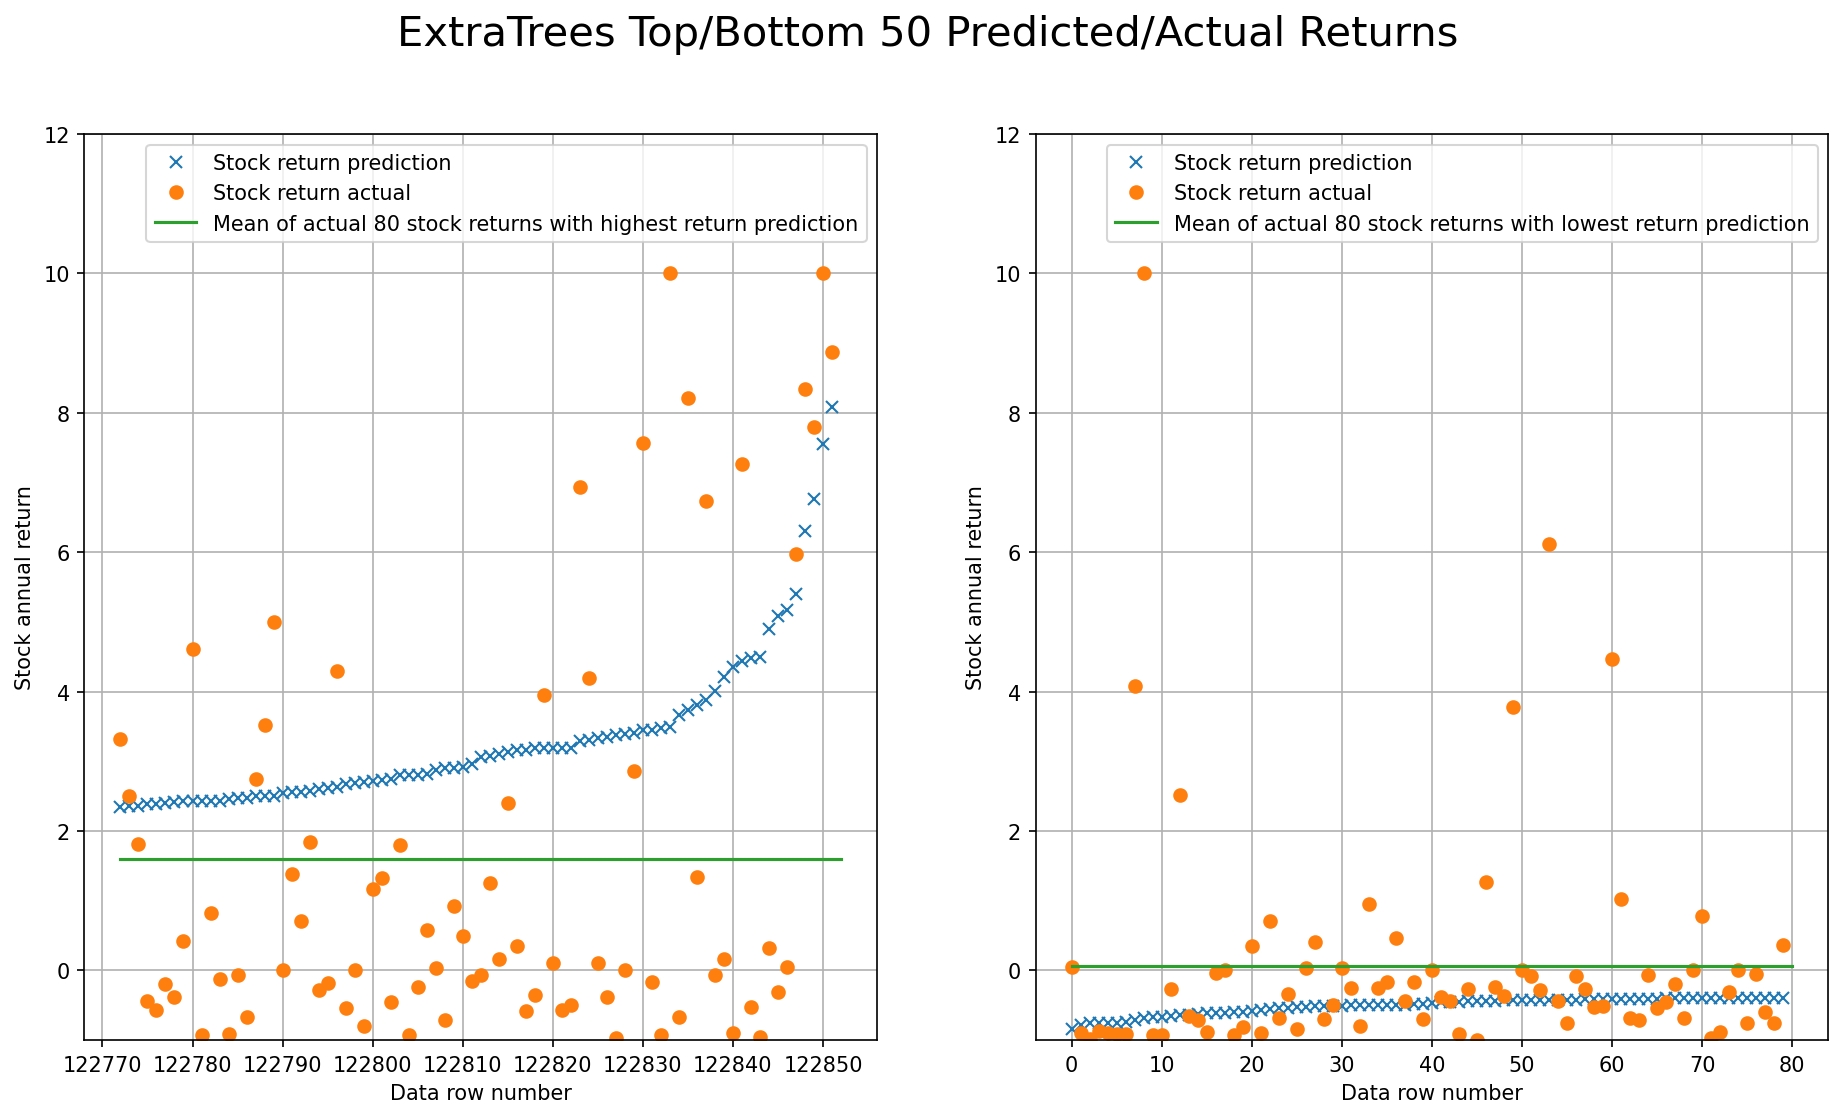

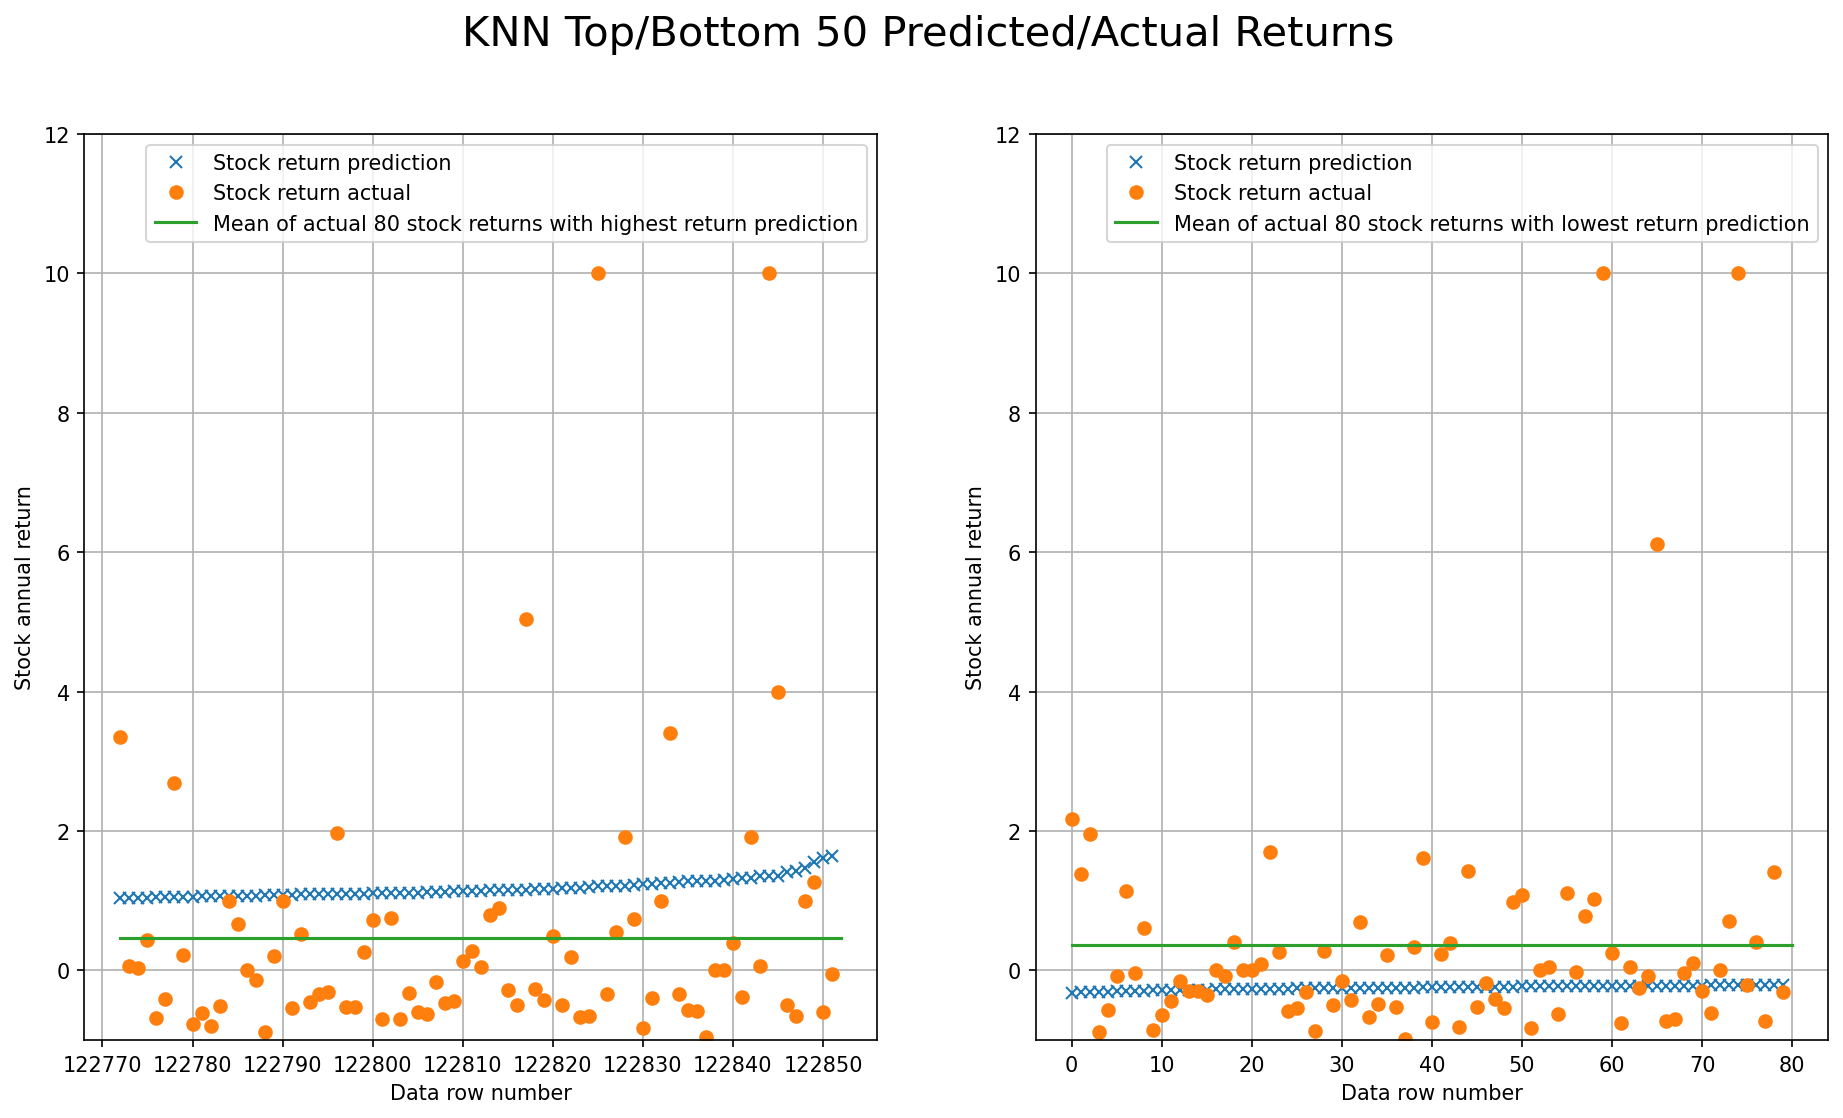

In [38]:
plotPredTgt(80, predInfo_ert, title='ExtraTrees Top/Bottom 50 Predicted/Actual Returns', sideBySide=True)
plotPredTgt(80, predInfo_knn, title='KNN Top/Bottom 50 Predicted/Actual Returns', sideBySide=True)

# Tweaking Regressors

In [13]:
def stockReturnsHyperparameter(regressor, parameters, parameterName, 
                               numRuns=10, verbose=False):
    '''
    Finds Performance for a regressor with varying hyperparameter.
    Performance is measured as top/bottom 20 stock predictions.
    Train/test split differs each time.
    Returns DataFrame of top/bottom 20 stock returns.
    '''
    returnCols = ['Predictor', parameterName, 
                  'Top20Return', 'Bottom20Return',
                  'Top20Return_withZscoreCutoff', 
                  'Bottom20Return_withZscoreCutoff']
    
    performance_df = pd.DataFrame(columns=returnCols)
    for parameter in parameters:
        for runNum in range(0,numRuns):
            X_train, X_test, y_train, y_test = \
            train_test_split(X, np.array(y).ravel(), test_size=0.5)
            
            regressor.set_params(**{parameterName : parameter})
            regressor.fit(X_train,y_train)      
            y_pred = regressor.predict(X_test)
            
            # get the prediction data WITHOUT Z score cut-off
            predData = getPredictionInfo(y_pred, y_test, X_test, 
                                         stockData, priceData)
            
            # get the prediction data WITH Z score cut-off
            predDataWithZScoreCutoff = getPredictionInfo(y_pred, y_test, X_test, 
                                                         stockData, priceData,
                                                         zScoreFilter=2.6)
            
            # Find the best and the worst predicted stocks
            bestTargets = predData['Target'].iloc[-20:]
            worstTargets = predData['Target'].iloc[:20]
            bestTargetsZScoreCutoff=predDataWithZScoreCutoff['Target'].iloc[-20:]
            worstTargetsZScoreCutoff=predDataWithZScoreCutoff['Target'].iloc[:20]
            
            # Get the name of our predictor
            if type(regressor).__name__ == 'Pipeline': 
                regressorName = type(regressor[1]).__name__
            else:
                regressorName = type(regressor).__name__
            
            # corresponding to returnCols
            results = [regressorName, parameter, 
                       np.mean(bestTargets), 
                       np.mean(worstTargets),
                       np.mean(bestTargetsZScoreCutoff), 
                       np.mean(worstTargetsZScoreCutoff)]
            if verbose:
                print(results)
            performance_df=\
            performance_df.append(pd.DataFrame([results], columns=returnCols), 
                                  ignore_index=True)

    return performance_df

## Extra Random Trees

In [18]:
parameterName = 'max_depth'
parameters = [5, 10, 20, 30, 50, 100, 200]
ert_regr = ExtraTreesRegressor(random_state=42, n_estimators=100, max_depth=100)
ert_validationCurve1 = stockReturnsHyperparameter(ert_regr, parameters, parameterName, verbose=True)
ert_validationCurve1.to_csv('ert_validationCurve1.csv')

['ExtraTreesRegressor', 5, 0.5336009986552025, 0.15838494267159225, 0.4644357846025725, 0.16048938658960857]
['ExtraTreesRegressor', 5, 1.100449607330837, -0.015515206316635189, 0.572420606983609, -0.2500383382816178]
['ExtraTreesRegressor', 5, 0.10573904208920219, -0.11198736669004845, 0.4686579636728131, -0.14587148064386465]
['ExtraTreesRegressor', 5, 0.7377548394462712, -0.17566019980339695, 0.7308575850776975, -0.28690609916921544]
['ExtraTreesRegressor', 5, 0.47115278497664353, -0.20677095704981402, 0.8449638627373119, -0.17198136109816337]
['ExtraTreesRegressor', 5, 0.6113710351081678, -0.022864844632127103, 0.39571038054245344, -0.049064542946417246]
['ExtraTreesRegressor', 5, 0.8717218703888683, -0.22610195208682052, 0.22938646067880825, -0.08521635476936743]
['ExtraTreesRegressor', 5, 0.18051958867722978, 0.20886663357855545, 0.18749697998258927, 0.33257359998290126]
['ExtraTreesRegressor', 5, 0.5643167356520978, -0.1653402299780151, 0.8016105633433714, 0.05823689362368545]
[

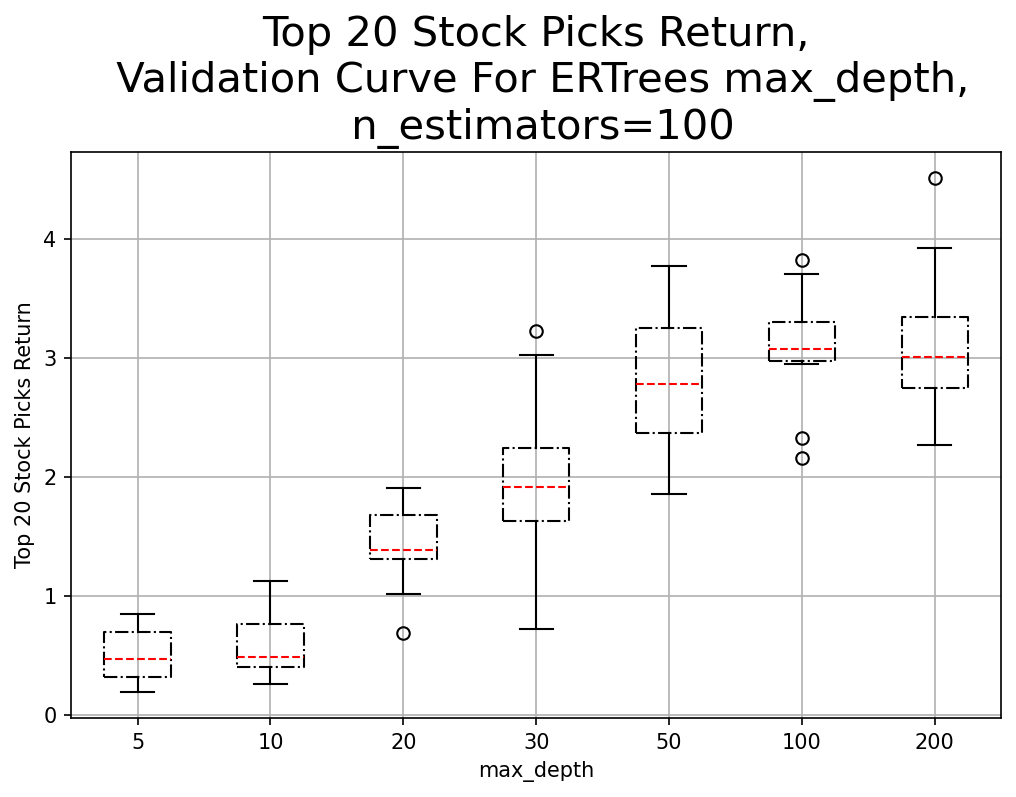

In [23]:
ert_validCurve=pd.read_csv('ert_validationCurve1.csv')

col_title = 'Top20Return_withZscoreCutoff'
plt.figure(figsize=(8,5))
plt.boxplot([ert_validCurve[ert_validCurve[parameterName]==5][col_title],
             ert_validCurve[ert_validCurve[parameterName]==10][col_title],
             ert_validCurve[ert_validCurve[parameterName]==20][col_title],
             ert_validCurve[ert_validCurve[parameterName]==30][col_title],
             ert_validCurve[ert_validCurve[parameterName]==50][col_title],
             ert_validCurve[ert_validCurve[parameterName]==100][col_title],
             ert_validCurve[ert_validCurve[parameterName]==200][col_title]],
             labels=parameters,
            medianprops={'color':'r',
                         'linestyle':'--'},
            boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.xlabel(parameterName)
plt.title('Top 20 Stock Picks Return,\n Validation Curve For ERTrees max_depth,\n n_estimators=100', fontsize=20);

In [15]:
ert_regr = ExtraTreesRegressor(random_state=42, n_estimators=100, max_depth=100)
parameterName = 'n_estimators'
parameters = [10, 20, 40, 100, 200, 400]
ert_validationCurve2 = stockReturnsHyperparameter(ert_regr, parameters, parameterName, verbose=True)

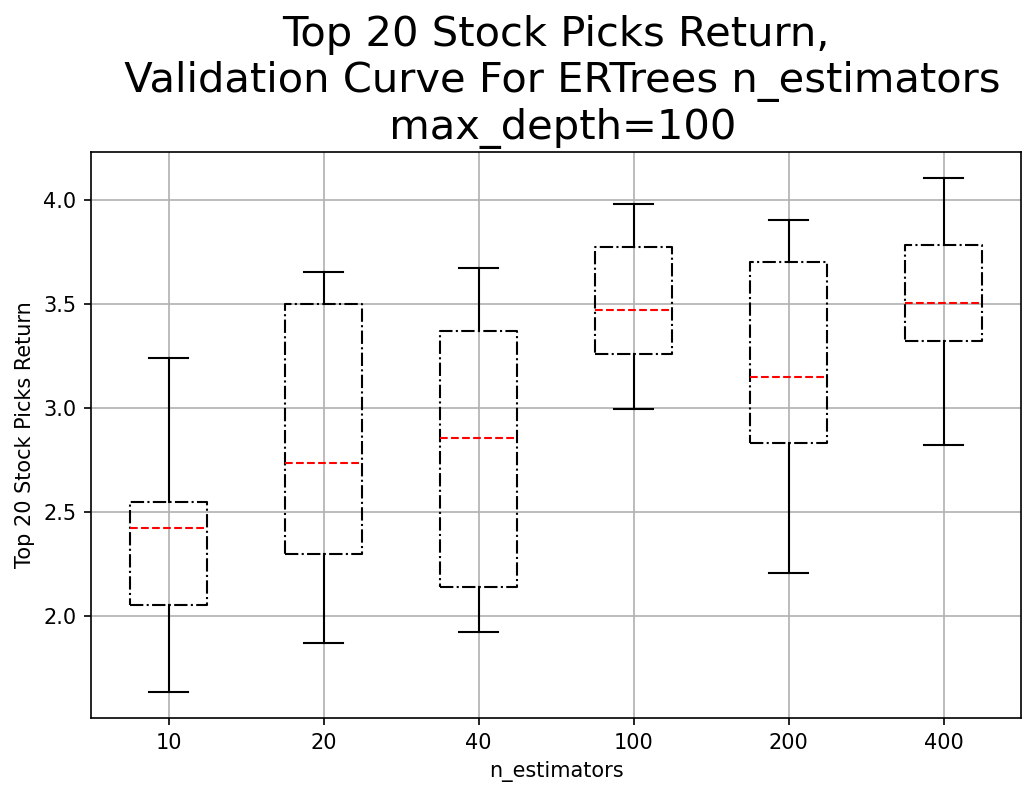

In [17]:
ert_validationCurve2.to_csv('ert_validationCurve2.csv')
ert_validationCurve2=pd.read_csv('ert_validationCurve2.csv')
plt.figure(figsize=(8,5))
plt.boxplot([ert_validationCurve2[ert_validationCurve2[parameterName]==10]['Top20Return_withZscoreCutoff'],
             ert_validationCurve2[ert_validationCurve2[parameterName]==20]['Top20Return_withZscoreCutoff'],
             ert_validationCurve2[ert_validationCurve2[parameterName]==40]['Top20Return_withZscoreCutoff'],
             ert_validationCurve2[ert_validationCurve2[parameterName]==100]['Top20Return_withZscoreCutoff'],
             ert_validationCurve2[ert_validationCurve2[parameterName]==200]['Top20Return_withZscoreCutoff'],
             ert_validationCurve2[ert_validationCurve2[parameterName]==400]['Top20Return_withZscoreCutoff']],
             labels=parameters,
            medianprops={'color':'r',
                         'linestyle':'--'},
            boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.xlabel(parameterName)
plt.title('Top 20 Stock Picks Return,\n Validation Curve For ERTrees n_estimators\n max_depth=100', fontsize=20);

## Random Forest

In [33]:
rf_regr = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=100)
parameterName = 'max_depth'
parameters = [5, 10, 20, 30, 50, 100, 200]
rf_validationCurve = stockReturnsHyperparameter(rf_regr, parameters, parameterName, verbose=True)
rf_validationCurve.to_csv('rf_validationCurve.csv')

['RandomForestRegressor', 5, 1.7777518273515132, 3.7972608946065574, -0.15513944224961737, 0.9703681087711212]
['RandomForestRegressor', 5, 0.5112882847281204, 3.045208276234597, -0.28691910063178233, 0.7415676505075124]
['RandomForestRegressor', 5, 0.7624204207615783, 3.0689031667232065, -0.2771336132527661, 0.7759080697244024]
['RandomForestRegressor', 5, 1.5416250074894031, 2.930785638589871, -0.08253868163898095, 0.8895146134572931]
['RandomForestRegressor', 5, 0.8515131979392028, 2.8418858309706363, -0.14596910819613876, 0.6346015562878439]
['RandomForestRegressor', 5, 0.8637596122232611, 2.7324214244324128, -0.28124189419519163, 0.5754594218029195]
['RandomForestRegressor', 5, 2.099465419627978, 3.0822853960426952, 0.0004988183339099478, 0.7374069706881173]
['RandomForestRegressor', 5, 0.2840233716553601, 2.269498810930519, 0.03752719646149073, 0.9462467387733146]
['RandomForestRegressor', 5, 0.6692010161851555, 3.054896569666231, -0.25664551414781905, 0.7083206574464878]
['Rando

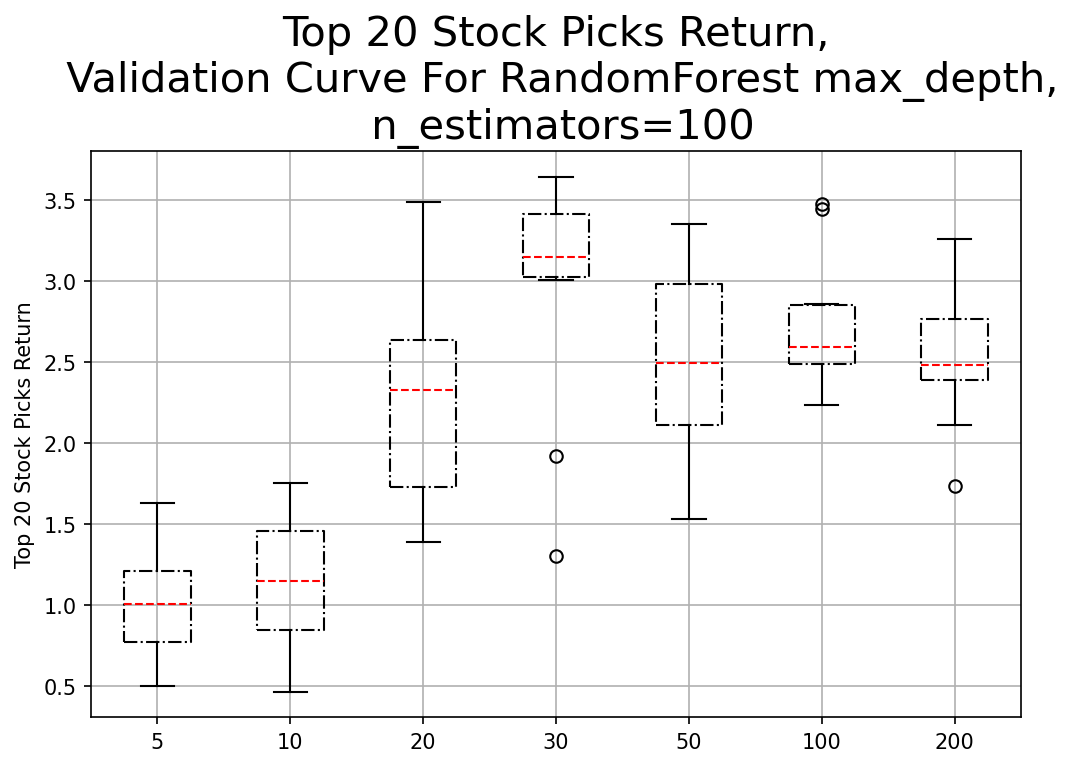

In [30]:
col_title = 'Top20Return_withZscoreCutoff'
rf_validationCurve=pd.read_csv('rf_validationCurve.csv')
parameters = [5, 10, 20, 30, 50, 100, 200]
plt.figure(figsize=(8,5))
plt.boxplot([rf_validationCurve[rf_validationCurve[parameterName]==5][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==10][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==20][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==30][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==50][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==100][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==200][col_title]],
             labels=parameters,
            medianprops={'color':'r',
                         'linestyle':'--'},
            boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.title('Top 20 Stock Picks Return,\n Validation Curve For RandomForest max_depth,\n n_estimators=100', fontsize=20);

In [ ]:
rf_regr = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=30)
parameterName = 'n_estimators'
parameters = [100, 200, 300, 500]
rf_validationCurve2 = stockReturnsHyperparameter(rf_regr, parameters, parameterName, verbose=True)
rf_validationCurve2.to_csv('rf_validationCurve2.csv')

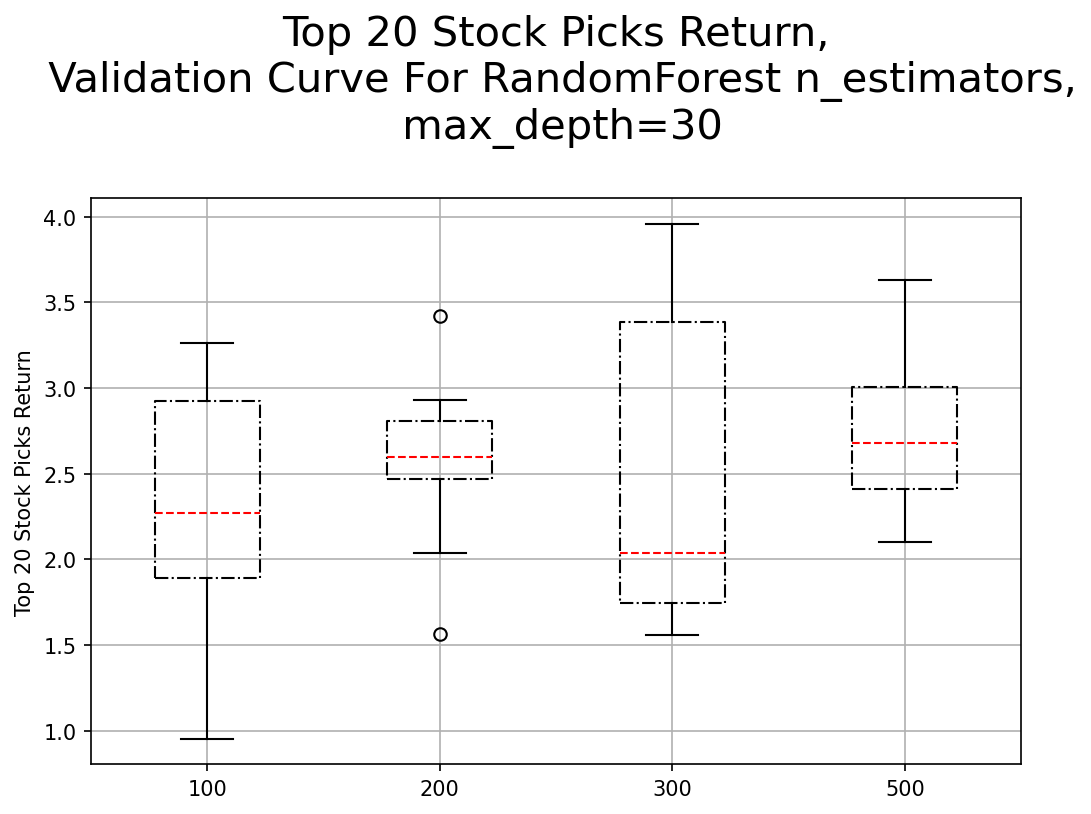

In [47]:
rf_validationCurve=pd.read_csv('rf_validationCurve2.csv')
parameterName = 'n_estimators'
parameters = [100, 200, 300, 500]

col_title = 'Top20Return_withZscoreCutoff'

plt.figure(figsize=(8,5))
plt.boxplot([rf_validationCurve[rf_validationCurve[parameterName]==100][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==200][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==300][col_title],
             rf_validationCurve[rf_validationCurve[parameterName]==500][col_title]],
             labels=parameters,
            medianprops={'color':'r',
                         'linestyle':'--'},
            boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.title('Top 20 Stock Picks Return,\n Validation Curve For RandomForest n_estimators,\n max_depth=30\n ', fontsize=20);

## Gradient Boosted Decision Tree

In [14]:
gbst_regr = GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=100)
gbst_regr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 2,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [24]:
# Takes a long time
parameterName = 'max_depth'
parameters = [2,3,4,5,10,20,40,80]

gbst_validationCurve1 = stockReturnsHyperparameter(gbst_regr, parameters, parameterName, verbose=True)
gbst_validationCurve1.to_csv('gbst_validationCurve.csv', mode='a', header=True)

['GradientBoostingRegressor', 2, -0.14371662173882946, -0.1574848943677504, 0.23254535728267464, -0.08982571081552909]
['GradientBoostingRegressor', 2, 0.006766470823658835, 0.7835791197555375, 0.09006853211586358, -0.20132064619856224]
['GradientBoostingRegressor', 2, 0.9555077979414911, -0.27558223259208814, 1.0511099920493685, -0.04272546241408757]
['GradientBoostingRegressor', 2, 0.1922638861349592, -0.18806632798736103, 0.14707100429537304, -0.17755458548076658]
['GradientBoostingRegressor', 2, 0.6075386143609232, 0.14573303147538066, 0.6343878686171376, 0.2216955545949096]
['GradientBoostingRegressor', 2, -0.019743287281487602, -0.29321325398503584, 0.8545971580232493, -0.022750491243551444]
['GradientBoostingRegressor', 2, 0.5693864899512728, -0.1646106169920931, 0.8935307364790879, -0.22140591896871298]
['GradientBoostingRegressor', 2, 0.8876860090239095, -0.36318747521378664, 0.4153974180409875, -0.08492478846053612]
['GradientBoostingRegressor', 2, 0.128905547502981, 0.046289

['GradientBoostingRegressor', 80, 0.11342223867968342, 0.12107435612592543, 0.5248112234701858, -0.10530292618105777]
['GradientBoostingRegressor', 80, 0.7610503694764197, -0.057565630856386954, 0.444047455251217, 0.1168446572448936]
['GradientBoostingRegressor', 80, 0.17129507244974235, 0.26694330083693185, 0.13512966286939412, 0.23053960758809863]
['GradientBoostingRegressor', 80, -0.2024603406800168, 0.8012531395199259, -7.697338723672287e-05, -0.03661589403292304]
['GradientBoostingRegressor', 80, 0.1404386461019344, 0.4270180453521874, 0.855285519934386, 0.1961576429396593]
['GradientBoostingRegressor', 80, 0.06196188249458012, 0.2805196770044857, 0.5893978349083782, 0.06604326029440422]
['GradientBoostingRegressor', 80, 0.45815539103720593, -0.18284605639658036, 0.27412146625053696, -0.16293009168873515]
['GradientBoostingRegressor', 80, 0.31619648542513823, -0.0345407233633809, 0.1381727777968142, -0.006373990697155163]
['GradientBoostingRegressor', 80, 0.8594078480466774, 0.047

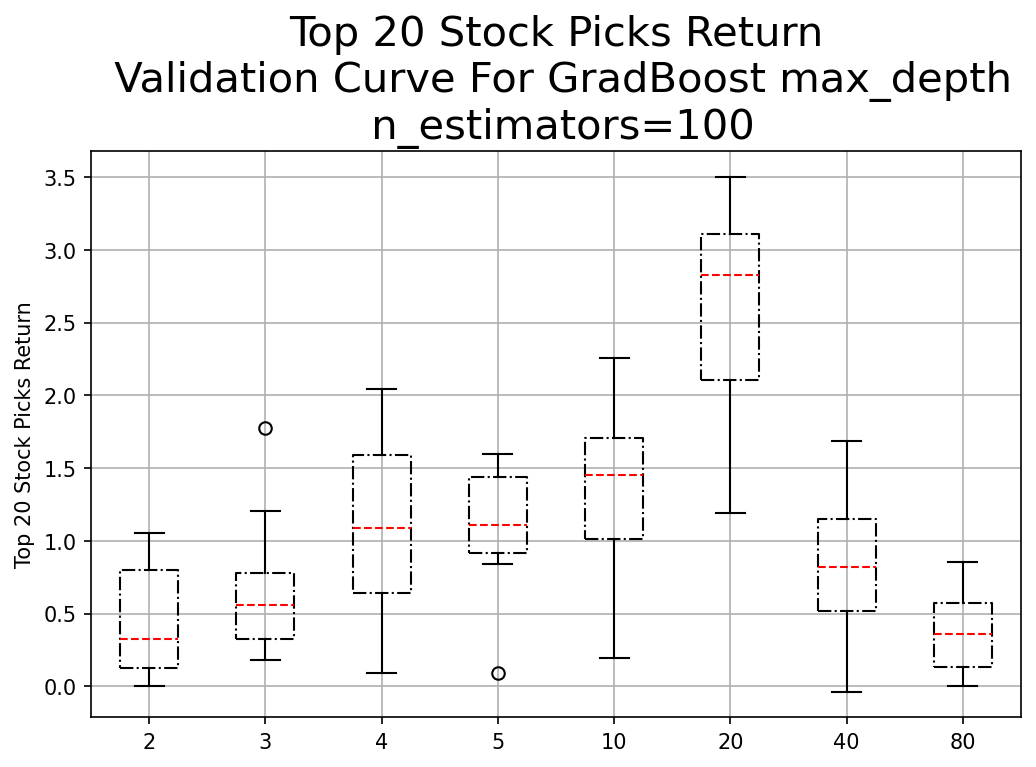

In [40]:
gbst_validationCurve=pd.read_csv('gbst_validationCurve.csv', index_col=0)
parameterName = 'max_depth'
parameters = [2,3,4,5,10,20,40,80]
col_title = 'Top20Return_withZscoreCutoff'

plt.figure(figsize=(8,5))
plt.boxplot([gbst_validationCurve[gbst_validationCurve[parameterName]==2][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==3][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==4][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==5][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==10][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==20][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==40][col_title],
             gbst_validationCurve[gbst_validationCurve[parameterName]==80][col_title]],
             labels=parameters,
             medianprops={'color':'r',
                          'linestyle':'--'},
             boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.title('Top 20 Stock Picks Return\n Validation Curve For GradBoost max_depth\n n_estimators=100', fontsize=20);

In [42]:
# Takes a long time
gbst_regr = GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=20)
parameterName = 'n_estimators'
parameters = [10,20,40,100,200,400]

gbst_validationCurve2 = stockReturnsHyperparameter(gbst_regr, parameters, parameterName, verbose=True)
gbst_validationCurve2.to_csv('gbst_validationCurve2.csv')

['GradientBoostingRegressor', 10, 1.0330342465676063, 0.5267103962958719, 1.0799317713173051, 0.23414705737913852]
['GradientBoostingRegressor', 10, 1.6074780846635022, 0.013983832465387378, 2.3377868011405694, -0.16615804886473676]
['GradientBoostingRegressor', 10, 0.5798924481396959, -0.13928582825653252, 1.3981322695997522, -0.03281683110395898]
['GradientBoostingRegressor', 10, 1.8194045985939318, 0.378810988136953, 1.0896352945771566, -0.07954268949178782]
['GradientBoostingRegressor', 10, 3.5131808254152324, -0.3666481304944969, 2.315815959206157, -0.10290398624405354]
['GradientBoostingRegressor', 10, 0.4587955658063553, 0.14096123836491967, 1.555916338234496, -0.06273970252111057]
['GradientBoostingRegressor', 10, 0.4684532947347108, 0.12298059960701146, 1.2867837073267556, -0.1844810492002124]
['GradientBoostingRegressor', 10, 1.8340223887085254, 0.4354666981229567, 1.7937768407387942, -0.22825692277085513]
['GradientBoostingRegressor', 10, 0.8687014689960778, 0.12388651642232

KeyboardInterrupt: 

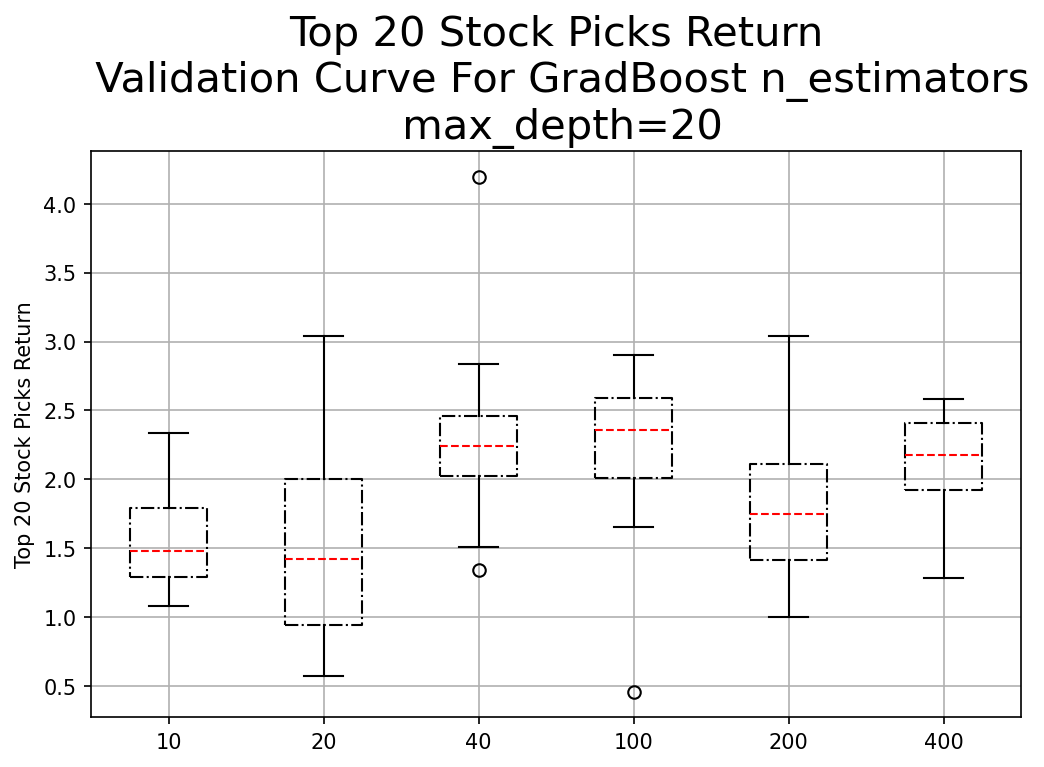

In [45]:
gbst_validationCurve2=pd.read_csv('gbst_validationCurve2.csv')
parameterName = 'n_estimators'
col_title = 'Top20Return_withZscoreCutoff'

plt.figure(figsize=(8,5))
plt.boxplot([gbst_validationCurve2[gbst_validationCurve2[parameterName]==10][col_title],
             gbst_validationCurve2[gbst_validationCurve2[parameterName]==20][col_title],
             gbst_validationCurve2[gbst_validationCurve2[parameterName]==40][col_title],
             gbst_validationCurve2[gbst_validationCurve2[parameterName]==100][col_title],
             gbst_validationCurve2[gbst_validationCurve2[parameterName]==200][col_title],
             gbst_validationCurve2[gbst_validationCurve2[parameterName]==400][col_title]],
             labels=[10,20,40,100,200,400],
            medianprops={'color':'r',
                         'linestyle':'--'},
            boxprops={'linestyle':'-.'}
            );
plt.grid()
plt.ylabel('Top 20 Stock Picks Return');
plt.title('Top 20 Stock Picks Return\n Validation Curve For GradBoost n_estimators\n max_depth=20', fontsize=20);